In [1]:
# %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import datetime
import math
# plt.style.use('seaborn-white')

x_min = -20
x_max = 20

def griewank(x, gamma=4000):
    n = len(x)
    indices = np.array(range(1, n+1))
    sum_term = np.sum(x*x/gamma)
    prod_term = np.prod(np.cos(x/np.sqrt(indices)))
    return 1 + sum_term - prod_term


def plot_griewank():
    n = 100
    x = np.linspace(x_min, x_max, n)
    y = np.linspace(x_min, x_max, n)

    X, Y = np.meshgrid(x, y)
    Z = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            x = np.array([X[i][j], Y[i][j]])
            Z[i][j] = griewank(x)

    plt.contour(X, Y, Z, cmap='RdGy')
    plt.colorbar()


def grad_griewank(x, gamma=4000):
    n = len(x)
    indices = np.array(range(1, n+1))
    grad = [2*x[i]/gamma + np.prod(np.cos(x/np.sqrt(indices))) * (1/np.cos(x[i] / np.sqrt(i+1))) * np.sin(x[i] / np.sqrt(i+1)) * (1.0 / np.sqrt(i+1)) for i in range(n)]
    return np.array(grad)


def hessian_griewank(x, gamma=4000):
    hessian = np.zeros([2, 2])
    hessian[0][0] = 2.0/gamma + np.cos(x[1]/np.sqrt(2))*np.cos(x[0])
    hessian[0][1] = hessian[1][0] = (-1/np.sqrt(2))*np.sin(x[0])*np.sin(x[1]/np.sqrt(2))
    hessian[1][1] = (2.0/gamma) + 0.5*np.cos(x[0])*np.cos(x[1]/np.sqrt(2))
    return hessian


def grad_is_approx_zero(grad, epsilon=1e-5):
    for grad_val in grad:
        if abs(grad_val) > epsilon:
            return False
    return True


def steepest_descent_griewank(x0, alpha=0.01, epsilon=1e-5, n_iter=10000, debug=False, gamma=4000, use_ebls=True):
    x_vals = []
    obj_vals = []
    grad_vals = []

    n = len(x0)
    x_curr = x0
    for i in range(n_iter):
        if debug:
            print("------------------------")
            print("Iteration: ", i)
            print(x_curr, griewank(x_curr, gamma))
            print("------------------------")

        grad = grad_griewank(x_curr, gamma)

        x_vals.append(x_curr)
        obj_vals.append(griewank(x_curr, gamma))
        grad_vals.append(grad)

        if grad_is_approx_zero(grad, epsilon):
            if debug:
                print("Solution found!", x_curr, griewank(x_curr, gamma), grad)
            break
        if use_ebls:
        	alpha = ebls(x_curr)
        x_next = x_curr - alpha*grad
        x_curr = x_next
    results_df = pd.DataFrame({'x': x_vals, 'obj': obj_vals, 'grad': grad_vals})
    return x_curr, griewank(x_curr, gamma), results_df


def heavy_ball_griewank(x0, alpha=0.01, beta=0.9, epsilon=1e-5, n_iter=10000, debug=False, gamma=4000, use_ebls=True):
    x_vals = []
    obj_vals = []
    grad_vals = []

    n = len(x0)
    x_curr = x0
    x_prev = x0
    for i in range(n_iter):
    	if debug:
	        print("------------------------")
	        print("Iteration: ", i)
	        print(x_curr, griewank(x_curr, gamma))
	        print("------------------------")

        grad = grad_griewank(x_curr, gamma)

        x_vals.append(x_curr)
        obj_vals.append(griewank(x_curr, gamma))
        grad_vals.append(grad)

        if grad_is_approx_zero(grad, epsilon):
            if debug:
                print("Solution found!", x_curr, griewank(x_curr, gamma))
            break
        if use_ebls:
            alpha = ebls(x_curr)
        x_next = x_curr - alpha*grad + beta*(x_curr - x_prev)
        if debug:
            print("Momentum!", x_curr-x_prev)
        x_prev = x_curr
        x_curr = x_next
    results_df = pd.DataFrame({'x': x_vals, 'obj': obj_vals, 'grad': grad_vals})
    return x_curr, griewank(x_curr, gamma), results_df


def ebls(x_0, c1=0.1, c2=0.3, epsilon=1e-5, n_iter=1000, debug=False, gamma=4000):
    L = 0.0
    U = 1e100 # infinity
    alpha = 1
    x_curr = x_0
    n_iter = 0

    while True:
        n_iter += 1
        grad_curr = grad_griewank(x_curr, gamma)
        d = -1 * grad_curr
        grad_next = grad_griewank(x_curr + alpha*d, gamma)
        f_next = griewank(x_curr + alpha*d, gamma)
        f_curr = griewank(x_curr)
        if f_next > (f_curr + c1*alpha*np.matmul(grad_curr.T, d)):
            U = alpha
            alpha = (U + L)/2.0
        elif np.matmul(grad_next.T, d) < c2*(np.matmul(grad_curr.T, d)):
            L = alpha
            if U >= 1e100:
                alpha = 2*L
            else:
                alpha = (L + U)/2.0
        else:
            return alpha


def run_griewank_test(algo='steepest_descent', gamma=4000, n_iter=1000, alpha=0.01, beta=0.9, use_ebls=True):
    results = {'x_opt': [], 'iterations': [], 'f_opt': [], 'x_0': [], 'dist_from_start': [], 'start_distance': []}
    print "Running test.", datetime.datetime.now()
    for i in range(n_iter):
        # print("Random Restart: {}".format(i))
        x_0 = np.random.uniform(low=x_min, high=x_max, size=2)
        if algo == 'steepest_descent':
        	x_opt, f_opt, results_df = steepest_descent_griewank(x_0, alpha=alpha, gamma=gamma, use_ebls=use_ebls)
        elif algo == 'heavy_ball':
        	x_opt, f_opt, results_df = heavy_ball_griewank(x_0, alpha=alpha, beta=beta, gamma=gamma, use_ebls=use_ebls)
        elif algo == 'nesterov':
            x_opt, f_opt, results_df = nesterov_griewank(x_0, alpha=alpha, beta=beta, gamma=gamma)
        else:
        	print "No such algorithm bro. The dude abides."
        	return -1
        results['x_opt'].append(x_opt)
        results['iterations'].append(results_df.shape[0])
        results['f_opt'].append(f_opt)
        results['x_0'].append(x_0)
        results['dist_from_start'].append(np.linalg.norm(x_opt - x_0))
        results['start_distance'].append(np.linalg.norm(x_0))
    results_df = pd.DataFrame(results)
    results_df['dist_to_origin'] = results_df.apply(lambda row: np.linalg.norm(row['x_opt']), axis=1)
    n_iter_list.append(n_iter)
    gamma_list.append(gamma)
    exp = algo + "_with_ebls" if use_ebls else algo + "_without_ebls" 
    experiment_list.append(exp)
    alpha_list.append(alpha)
    beta_list.append(beta)
    print "Test complete."
    return results_df


def compare_descent_algorithms(gamma=4000, n_iter=1000, max_iter=10000, alpha=1, beta=0.98):
    def save_results(results_list, x_0, x_opt, f_opt, iter_to_convergence):
        results_list['dist_from_start'].append(np.linalg.norm(x_opt - x_0))
        results_list['dist_to_origin'].append(np.linalg.norm(x_opt))
        results_list['f_opt'].append(f_opt)
        results_list['iter_to_convergence'].append(iter_to_convergence)
        results_list['dist_moved_towards_origin'].append(np.linalg.norm(x_0) - np.linalg.norm(x_opt))

    start_distance = []
    sd_results = {'dist_from_start': [], 'f_opt': [], 'dist_to_origin': [], 'iter_to_convergence': [], 'dist_moved_towards_origin': []}
    sd_ebls_results = {'dist_from_start': [], 'f_opt': [], 'dist_to_origin': [], 'iter_to_convergence': [], 'dist_moved_towards_origin': []}
    hball_results = {'dist_from_start': [], 'f_opt': [], 'dist_to_origin': [], 'iter_to_convergence': [], 'dist_moved_towards_origin': []}
    nesterov_results = {'dist_from_start': [], 'f_opt': [], 'dist_to_origin': [], 'iter_to_convergence': [], 'dist_moved_towards_origin': []}

    for i in range(n_iter):
        if i%100 == 0:
            print("Random Restart: {}".format(i))
        x_0 = np.random.uniform(low=x_min, high=x_max, size=2)
        start_distance.append(np.linalg.norm(x_0))
        
        x_opt, f_opt, results_df = steepest_descent_griewank(x_0, alpha=alpha, gamma=gamma, use_ebls=False)
        save_results(sd_results, x_0, x_opt, f_opt, results_df.shape[0])

        x_opt, f_opt, results_df = steepest_descent_griewank(x_0, alpha=alpha, gamma=gamma, use_ebls=True)
        save_results(sd_ebls_results, x_0, x_opt, f_opt, results_df.shape[0])
        
        x_opt, f_opt, results_df = heavy_ball_griewank(x_0, alpha=alpha, beta=beta, gamma=gamma, use_ebls=False)
        save_results(hball_results, x_0, x_opt, f_opt, results_df.shape[0])
        
        x_opt, f_opt, results_df = nesterov_griewank(x_0, alpha=alpha, beta=beta, gamma=gamma, use_ebls=False)
        save_results(nesterov_results, x_0, x_opt, f_opt, results_df.shape[0])


    f_opt_df = pd.DataFrame()
    dist_to_origin_df = pd.DataFrame()
    dist_from_start_df = pd.DataFrame()
    dist_moved_towards_origin_df = pd.DataFrame()

    algo_results_map = {'sdesc': sd_results, 'sdesc_ebls': sd_ebls_results, 'heavy ball': hball_results, 'nestrov': nesterov_results}
    aggregated_results_df = {'algo': [], 'start_distance': [], 'dist_from_start': [], 'dist_to_origin': [],
                            'f_opt': [], 'iter_to_convergence': [], 'dist_moved_towards_origin': []}
    for algo in algo_results_map.keys():
        results = algo_results_map[algo]
        aggregated_results_df['algo'].append(algo)
        aggregated_results_df['start_distance'].append(np.mean(start_distance))
        aggregated_results_df['dist_from_start'].append(np.mean(results['dist_from_start']))
        aggregated_results_df['dist_to_origin'].append(np.mean(results['dist_to_origin']))
        aggregated_results_df['f_opt'].append(np.mean(results['f_opt']))
        aggregated_results_df['iter_to_convergence'].append(np.mean(results['iter_to_convergence']))
        aggregated_results_df['dist_moved_towards_origin'].append(np.mean(results['dist_moved_towards_origin']))

        f_opt_df[algo + '_f_opt'] = pd.Series(results['f_opt'])
        dist_to_origin_df[algo + '_d'] = pd.Series(results['dist_to_origin'])
        dist_from_start_df[algo + '_d'] = pd.Series(results['dist_from_start'])
        dist_moved_towards_origin_df[algo + '_d'] = pd.Series(results['dist_moved_towards_origin'])
        plot_aggregates(f_opt_df, dist_to_origin_df, dist_from_start_df, dist_moved_towards_origin_df)

    aggregated_results_df = pd.DataFrame(aggregated_results_df)
    print aggregated_results_df
    return aggregated_results_df


mean_f_opt = []
mean_dist_to_origin = []
mean_dist_from_start = []
mean_start_distance = []
mean_iter_to_convergence = []
experiment_list = []
n_iter_list = []
gamma_list = []
alpha_list = []
beta_list = []


def save_figure(ax, filename):
    fig = ax.get_figure()
    fig.savefig(filename)
    fig.clear()
    plt.close()

def save_results(df, f_opt_df, dist_to_origin_df, dist_from_start_df, filename, hist=True):
    df.to_csv(filename + '.csv')
    mean_f_opt.append(df.f_opt.mean())
    mean_dist_to_origin.append(df.dist_to_origin.mean())
    mean_dist_from_start.append(df.dist_from_start.mean())
    mean_start_distance.append(df.start_distance.mean())
    mean_iter_to_convergence.append(df.iterations.mean())
    if hist:
        f_opt_df[filename + '_f_opt'] = df['f_opt']
        dist_to_origin_df[filename + '_d'] = df['dist_to_origin']
        dist_from_start_df[filename + '_d'] = df['dist_from_start']

        ax = df.dist_to_origin.hist()
        fig = ax.get_figure()
        fig.savefig(filename + ".pdf")
        fig.clear()

def plot_aggregates(f_opt_df, dist_to_origin_df, dist_from_start_df, dist_moved_towards_origin_df):
    filenames = ['f_opt_aggregated.pdf', 'dist_to_origin_aggregated.pdf',
                    'dist_from_start_aggregated.pdf', 'dist_moved_towards_origin.pdf']
    for i, df in enumerate([f_opt_df, dist_to_origin_df, dist_from_start_df, dist_moved_towards_origin_df]):
        ax = df.plot.hist(alpha=0.5)
        save_figure(ax, 'hist_' + filenames[i])
        ax = df.plot.box()
        save_figure(ax, 'box_' + filenames[i])


def driver(n_iter=100, gamma=500, alpha=1, beta=0.99):
    f_opt_df = pd.DataFrame()
    dist_to_origin_df = pd.DataFrame()
    dist_from_start_df = pd.DataFrame()
    df = run_griewank_test('steepest_descent', gamma=gamma, n_iter=n_iter, alpha=alpha, beta=beta, use_ebls=False)
    save_results(df, f_opt_df, dist_to_origin_df, dist_from_start_df, 'sdesc')
    df = run_griewank_test('steepest_descent', gamma=gamma, n_iter=n_iter, alpha=alpha, beta=beta, use_ebls=True)
    save_results(df, f_opt_df, dist_to_origin_df, dist_from_start_df, 'sdesc_ebls')
    df = run_griewank_test('heavy_ball', gamma=gamma, n_iter=n_iter, alpha=alpha, beta=beta, use_ebls=False)
    save_results(df, f_opt_df, dist_to_origin_df, dist_from_start_df, 'hball')
    # df = run_griewank_test('heavy_ball', gamma=gamma, n_iter=n_iter, alpha=alpha, beta=beta, use_ebls=True)
    # save_results(df, f_opt_df, dist_to_origin_df, dist_from_start_df, 'hball_ebls', False)
    df = run_griewank_test('nesterov', gamma=gamma, n_iter=n_iter, alpha=alpha, beta=beta, use_ebls=False)
    save_results(df, f_opt_df, dist_to_origin_df, dist_from_start_df, 'nesterov')

    df = pd.DataFrame({'experiment': experiment_list, 'mean_f_opt': mean_f_opt, 'mean_dist_to_origin': mean_dist_to_origin,
    					'mean_dist_from_start': mean_dist_from_start, 'mean_start_distance': mean_start_distance,
                        'mean_iter_to_convergence': mean_iter_to_convergence, 'max_iter': n_iter_list,
                        'gamma': gamma_list, 'alpha': alpha_list, 'beta': beta_list})
    df.to_csv("aggregated_results.csv")
    plot_aggregates(f_opt_df, dist_to_origin_df, dist_from_start_df)

    print "Aggregated Results:"
    print df
    return df

def beta_grid_search(n_iter=100, beta_values=None, gamma=500, alpha=1):
    beta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.87, 0.89, 0.90, 0.91,
            0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.999]
    results_dict = {'beta': [], 'dist_from_start': [], 'dist_to_origin': [], 'f_opt': [], 'start_distance': []}
    for beta in beta_values:
        print "beta:", beta
        df = run_griewank_test('heavy_ball', gamma=gamma, n_iter=n_iter, alpha=alpha, beta=beta, use_ebls=False)
        results_dict['beta'].append(beta)
        results_dict['dist_from_start'].append(df.dist_from_start.mean())
        results_dict['dist_to_origin'].append(df.dist_to_origin.mean())
        results_dict['f_opt'].append(df.f_opt.mean())
        results_dict['start_distance'].append(df.start_distance.mean())
    return pd.DataFrame(results_dict)


def get_rho_k(rho_k_minus_1 = 0):
    a = -1.0
    b = (rho_k_minus_1**2 - 1)
    c = 1.0
    rho_k = (-b - math.sqrt(b**2 - 4*a*c))/2*a
    return rho_k


def nesterov_griewank(x0, alpha=1, beta=0.98, epsilon=1e-5, n_iter=1000, debug=False, gamma=500, use_ebls=False, rho=0):
    x_vals = []
    obj_vals = []
    grad_vals = []

    n = len(x0)
    x_curr = x0
    x_prev = x0
    rho_prev = rho
    for i in range(n_iter):
        if debug:
            print("------------------------")
            print("Iteration: ", i)
            print(x_curr, griewank(x_curr, gamma))
            print("------------------------")
        
        rho_curr = get_rho_k(rho_prev)
        beta = rho_curr*(rho_prev**2)
        rho_prev = rho_curr
        
        y_curr = x_curr + beta*(x_curr - x_prev)
        grad = grad_griewank(y_curr, gamma)

        x_vals.append(x_curr)
        obj_vals.append(griewank(x_curr, gamma))
        grad_vals.append(grad)

        if grad_is_approx_zero(grad, epsilon):
            if debug:
                print("Solution found!", x_curr, griewank(x_curr, gamma))
            break
        x_next = y_curr - alpha*grad
        x_prev = x_curr
        x_curr = x_next
    results_df = pd.DataFrame({'x': x_vals, 'obj': obj_vals, 'grad': grad_vals})
    return x_curr, griewank(x_curr, gamma), results_df


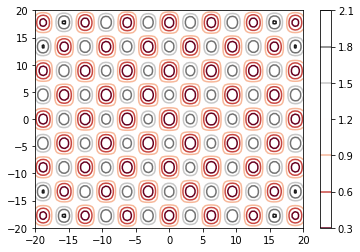

In [2]:
plot_griewank()

Running test. 2019-10-13 19:54:12.664738
Test complete.
       dist_from_start         f_opt   iterations  start_distance  \
count       100.000000  1.000000e+02   100.000000      100.000000   
mean          2.046384  5.675226e-01  2312.840000       15.620217   
std           0.743736  3.544632e-01   268.265914        5.662203   
min           0.113687  9.857326e-11  1175.000000        1.478015   
25%           1.587971  3.145688e-01  2180.500000       12.195744   
50%           2.119681  5.294276e-01  2343.500000       16.447799   
75%           2.598704  8.439926e-01  2473.500000       19.547905   
max           4.060898  1.470615e+00  3014.000000       26.366818   

       dist_to_origin  
count      100.000000  
mean        15.712780  
std          5.955293  
min          0.000020  
25%         12.516285  
50%         16.215966  
75%         20.484305  
max         27.025970  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1122c0e90>,
      dtype=object)

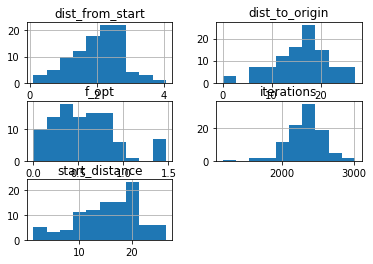

In [3]:
steepest_descent_results_df = run_griewank_test('steepest_descent', gamma=500, n_iter=100, alpha=0.01, beta=0.99, use_ebls=False)
print steepest_descent_results_df.describe()
steepest_descent_results_df.hist()

In [4]:
def hessian_griewank(x, gamma=4000):
    hessian = np.zeros([2, 2])
    hessian[0][0] = 2.0/gamma + np.cos(x[1]/np.sqrt(2))*np.cos(x[0])
    hessian[0][1] = hessian[1][0] = (-1/np.sqrt(2))*np.sin(x[0])*np.sin(x[1]/np.sqrt(2))
    hessian[1][1] = (2.0/gamma) + 0.5*np.cos(x[0])*np.cos(x[1]/np.sqrt(2))
    return hessian

In [5]:
x = np.random.uniform(x_min, x_max, size=2)
print x
hess = hessian_griewank(x)
print hess

[-5.05851661 19.95334945]
[[ 0.01000416 -0.66490968]
 [-0.66490968  0.00525208]]


In [6]:
w,v = np.linalg.eig(hess)

In [7]:
w

array([ 0.67254204, -0.6572858 ])

In [8]:
print w.min(), w.max()

-0.6572858041916404 0.6725420419226954


In [3]:
def get_approx_L(gamma=4000):
    L = -1
    for i in range(10000):
        x = np.random.uniform(low=x_min, high=x_max, size=2)
        hess = hessian_griewank(x, gamma)
        max_eig = np.max(np.linalg.eig(hess)[0])
        # print max_eig
        if max_eig > L:
            L = max_eig
    return L

In [8]:
for gamma in [0.1, 1, 100, 500, 1000, 1500, 2000, 3000, 100000]:
    print gamma, get_approx_L(gamma)

0.1 20.99997231970863
1 2.9999959350338496
100 1.0196968161204572
500 1.0029097247653924
1000 1.0018823980310558
1500 1.0010213359648763
2000 1.0009046480061556
3000 1.000418753664212
100000 0.9999978385451519


In [15]:
df = compare_descent_algorithms(gamma=500, n_iter=100)

Random Restart: 0
         algo  dist_from_start  dist_moved_towards_origin  dist_to_origin  \
0       sdesc         2.159336                   0.068076       15.255802   
1  sdesc_ebls         2.247382                   0.256469       15.067409   
2     nestrov         2.159363                   0.068069       15.255810   
3  heavy ball         6.070163                   1.480706       13.843173   

      f_opt  iter_to_convergence  start_distance  
0  0.527734                19.55       15.323879  
1  0.516361              1224.41       15.323879  
2  0.527734                23.58       15.323879  
3  0.449249               924.14       15.323879  
